#### Imports

In [18]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix


#### Read in Dataset

In [2]:
dogs = pd.read_csv('../data/dogs.csv')

#### Feature Selection

In [3]:
dogs = dogs.dropna(subset=['outcome_type', 'intake_sex'])

In [4]:
features = [
    'intake_type',
    'intake_condition',
    'intake_sex',
    'intake_spay_neuter',
    'intake_age_in_years',
    'breed',
    'color',
    'found_city',
]

target = ['outcome_type']

In [5]:
dogs = dogs[
            (dogs['outcome_type'].isin(['Adoption', 'Return to Owner', 'Transfer', 'Euthanasia'])) &
            (dogs['intake_condition'] == 'Normal')
            ]

In [6]:
X = dogs[features]
y = dogs[target]

In [7]:
y['outcome_type'].value_counts()

Adoption           31392
Return to Owner    18277
Transfer           13037
Euthanasia          1028
Name: outcome_type, dtype: int64

In [8]:
#Combining Adoption since Transfers are initiated to increase liklihood of adoption

y = y['outcome_type'].str.replace('Adoption', 'Other')

In [9]:
y.value_counts()

Other              31392
Return to Owner    18277
Transfer           13037
Euthanasia          1028
Name: outcome_type, dtype: int64

In [10]:
y = y.str.replace('Transfer', 'Other')
y = y.str.replace('Euthanasia', 'Other')

In [11]:
y.value_counts()

Other              45457
Return to Owner    18277
Name: outcome_type, dtype: int64

#### CatBoost Category Columns

In [12]:
#CatBoost requires the specification of categorical columns. This function gets the list of categorical indicies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(X)

In [13]:
categorical_indicies

[0, 1, 2, 3, 5, 6, 7]

In [14]:
#CatBoost needs the categorical columns to be converted to the categorical datatype

def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')

convert_cats(X)

<ipython-input-14-6025a30c5164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


#### Train, Test, Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

#### SMOTE

In [19]:
oversampler = SMOTENC(k_neighbors=5, n_jobs=-1, random_state=63, categorical_features=categorical_indicies)

In [20]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

In [21]:
y_smote.value_counts()

Other              34140
Return to Owner    34140
Name: outcome_type, dtype: int64

#### Pool

In [27]:
train_dataset = Pool(X_smote, 
                     y_smote,
                     cat_features=categorical_indicies
                    )
test_dataset = Pool(X_test, 
                    y_test,
                    cat_features=categorical_indicies
                   )

#### Model Training and Prediction

In [28]:
clf = CatBoostClassifier()

clf.fit(train_dataset)

preds = clf.predict(test_dataset)

print(preds)

Learning rate set to 0.062543
0:	learn: 0.6656859	total: 32ms	remaining: 31.9s
1:	learn: 0.6417152	total: 63.9ms	remaining: 31.9s
2:	learn: 0.6223716	total: 94.5ms	remaining: 31.4s
3:	learn: 0.6050449	total: 118ms	remaining: 29.4s
4:	learn: 0.5899796	total: 141ms	remaining: 28.1s
5:	learn: 0.5751484	total: 170ms	remaining: 28.2s
6:	learn: 0.5640326	total: 197ms	remaining: 27.9s
7:	learn: 0.5535575	total: 238ms	remaining: 29.5s
8:	learn: 0.5448762	total: 264ms	remaining: 29s
9:	learn: 0.5383597	total: 292ms	remaining: 28.9s
10:	learn: 0.5311812	total: 325ms	remaining: 29.2s
11:	learn: 0.5250734	total: 354ms	remaining: 29.2s
12:	learn: 0.5196290	total: 378ms	remaining: 28.7s
13:	learn: 0.5137503	total: 416ms	remaining: 29.3s
14:	learn: 0.5089422	total: 451ms	remaining: 29.6s
15:	learn: 0.5044271	total: 483ms	remaining: 29.7s
16:	learn: 0.5006204	total: 520ms	remaining: 30.1s
17:	learn: 0.4968121	total: 551ms	remaining: 30.1s
18:	learn: 0.4935535	total: 593ms	remaining: 30.6s
19:	learn: 0

162:	learn: 0.4169552	total: 5.42s	remaining: 27.8s
163:	learn: 0.4169186	total: 5.45s	remaining: 27.8s
164:	learn: 0.4168151	total: 5.48s	remaining: 27.8s
165:	learn: 0.4166559	total: 5.51s	remaining: 27.7s
166:	learn: 0.4160040	total: 5.54s	remaining: 27.6s
167:	learn: 0.4159499	total: 5.58s	remaining: 27.6s
168:	learn: 0.4157140	total: 5.62s	remaining: 27.7s
169:	learn: 0.4156095	total: 5.65s	remaining: 27.6s
170:	learn: 0.4155095	total: 5.68s	remaining: 27.5s
171:	learn: 0.4153003	total: 5.72s	remaining: 27.5s
172:	learn: 0.4150985	total: 5.75s	remaining: 27.5s
173:	learn: 0.4147618	total: 5.78s	remaining: 27.4s
174:	learn: 0.4146810	total: 5.82s	remaining: 27.4s
175:	learn: 0.4145805	total: 5.86s	remaining: 27.4s
176:	learn: 0.4145560	total: 5.89s	remaining: 27.4s
177:	learn: 0.4145129	total: 5.92s	remaining: 27.4s
178:	learn: 0.4144125	total: 5.95s	remaining: 27.3s
179:	learn: 0.4142199	total: 5.98s	remaining: 27.3s
180:	learn: 0.4141207	total: 6.01s	remaining: 27.2s
181:	learn: 

322:	learn: 0.3966327	total: 10.6s	remaining: 22.3s
323:	learn: 0.3962332	total: 10.7s	remaining: 22.2s
324:	learn: 0.3959453	total: 10.7s	remaining: 22.2s
325:	learn: 0.3957860	total: 10.7s	remaining: 22.1s
326:	learn: 0.3956381	total: 10.7s	remaining: 22.1s
327:	learn: 0.3952539	total: 10.8s	remaining: 22.1s
328:	learn: 0.3952094	total: 10.8s	remaining: 22s
329:	learn: 0.3949443	total: 10.8s	remaining: 22s
330:	learn: 0.3949342	total: 10.9s	remaining: 22s
331:	learn: 0.3946758	total: 10.9s	remaining: 21.9s
332:	learn: 0.3945771	total: 10.9s	remaining: 21.9s
333:	learn: 0.3945142	total: 11s	remaining: 21.9s
334:	learn: 0.3944931	total: 11s	remaining: 21.9s
335:	learn: 0.3943820	total: 11s	remaining: 21.8s
336:	learn: 0.3943493	total: 11.1s	remaining: 21.8s
337:	learn: 0.3943070	total: 11.1s	remaining: 21.8s
338:	learn: 0.3941842	total: 11.2s	remaining: 21.8s
339:	learn: 0.3941168	total: 11.2s	remaining: 21.7s
340:	learn: 0.3940683	total: 11.3s	remaining: 21.8s
341:	learn: 0.3938832	to

484:	learn: 0.3871622	total: 16.2s	remaining: 17.2s
485:	learn: 0.3871418	total: 16.2s	remaining: 17.1s
486:	learn: 0.3871403	total: 16.2s	remaining: 17.1s
487:	learn: 0.3871195	total: 16.2s	remaining: 17s
488:	learn: 0.3870921	total: 16.3s	remaining: 17s
489:	learn: 0.3870672	total: 16.3s	remaining: 17s
490:	learn: 0.3870491	total: 16.3s	remaining: 16.9s
491:	learn: 0.3870246	total: 16.4s	remaining: 16.9s
492:	learn: 0.3870029	total: 16.4s	remaining: 16.8s
493:	learn: 0.3869770	total: 16.4s	remaining: 16.8s
494:	learn: 0.3869440	total: 16.4s	remaining: 16.8s
495:	learn: 0.3868205	total: 16.5s	remaining: 16.7s
496:	learn: 0.3867102	total: 16.5s	remaining: 16.7s
497:	learn: 0.3866974	total: 16.5s	remaining: 16.7s
498:	learn: 0.3866560	total: 16.6s	remaining: 16.6s
499:	learn: 0.3866552	total: 16.6s	remaining: 16.6s
500:	learn: 0.3866551	total: 16.6s	remaining: 16.6s
501:	learn: 0.3866411	total: 16.7s	remaining: 16.5s
502:	learn: 0.3866132	total: 16.7s	remaining: 16.5s
503:	learn: 0.3865

648:	learn: 0.3811628	total: 21.5s	remaining: 11.7s
649:	learn: 0.3811368	total: 21.6s	remaining: 11.6s
650:	learn: 0.3810629	total: 21.6s	remaining: 11.6s
651:	learn: 0.3810299	total: 21.6s	remaining: 11.5s
652:	learn: 0.3810009	total: 21.7s	remaining: 11.5s
653:	learn: 0.3809970	total: 21.7s	remaining: 11.5s
654:	learn: 0.3809080	total: 21.7s	remaining: 11.5s
655:	learn: 0.3809011	total: 21.8s	remaining: 11.4s
656:	learn: 0.3808527	total: 21.8s	remaining: 11.4s
657:	learn: 0.3808508	total: 21.8s	remaining: 11.3s
658:	learn: 0.3808442	total: 21.8s	remaining: 11.3s
659:	learn: 0.3807562	total: 21.9s	remaining: 11.3s
660:	learn: 0.3807329	total: 21.9s	remaining: 11.2s
661:	learn: 0.3807008	total: 21.9s	remaining: 11.2s
662:	learn: 0.3806646	total: 22s	remaining: 11.2s
663:	learn: 0.3806542	total: 22s	remaining: 11.1s
664:	learn: 0.3806368	total: 22.1s	remaining: 11.1s
665:	learn: 0.3805814	total: 22.1s	remaining: 11.1s
666:	learn: 0.3805684	total: 22.1s	remaining: 11s
667:	learn: 0.3804

811:	learn: 0.3767092	total: 27s	remaining: 6.26s
812:	learn: 0.3766937	total: 27.1s	remaining: 6.23s
813:	learn: 0.3766441	total: 27.1s	remaining: 6.2s
814:	learn: 0.3766270	total: 27.2s	remaining: 6.16s
815:	learn: 0.3765995	total: 27.2s	remaining: 6.13s
816:	learn: 0.3765930	total: 27.2s	remaining: 6.1s
817:	learn: 0.3765763	total: 27.3s	remaining: 6.06s
818:	learn: 0.3765437	total: 27.3s	remaining: 6.03s
819:	learn: 0.3765392	total: 27.3s	remaining: 6s
820:	learn: 0.3765192	total: 27.4s	remaining: 5.97s
821:	learn: 0.3765123	total: 27.4s	remaining: 5.94s
822:	learn: 0.3765085	total: 27.5s	remaining: 5.9s
823:	learn: 0.3764940	total: 27.5s	remaining: 5.87s
824:	learn: 0.3764517	total: 27.5s	remaining: 5.84s
825:	learn: 0.3763861	total: 27.6s	remaining: 5.81s
826:	learn: 0.3763610	total: 27.6s	remaining: 5.78s
827:	learn: 0.3763457	total: 27.7s	remaining: 5.74s
828:	learn: 0.3763306	total: 27.7s	remaining: 5.71s
829:	learn: 0.3761631	total: 27.7s	remaining: 5.68s
830:	learn: 0.376126

974:	learn: 0.3719389	total: 32.7s	remaining: 839ms
975:	learn: 0.3718974	total: 32.7s	remaining: 805ms
976:	learn: 0.3718813	total: 32.8s	remaining: 772ms
977:	learn: 0.3718677	total: 32.8s	remaining: 738ms
978:	learn: 0.3718507	total: 32.8s	remaining: 704ms
979:	learn: 0.3718143	total: 32.9s	remaining: 671ms
980:	learn: 0.3717779	total: 32.9s	remaining: 637ms
981:	learn: 0.3717028	total: 32.9s	remaining: 604ms
982:	learn: 0.3716252	total: 33s	remaining: 570ms
983:	learn: 0.3716145	total: 33s	remaining: 537ms
984:	learn: 0.3716105	total: 33s	remaining: 503ms
985:	learn: 0.3715795	total: 33.1s	remaining: 469ms
986:	learn: 0.3714784	total: 33.1s	remaining: 436ms
987:	learn: 0.3714408	total: 33.1s	remaining: 402ms
988:	learn: 0.3713990	total: 33.2s	remaining: 369ms
989:	learn: 0.3713941	total: 33.2s	remaining: 335ms
990:	learn: 0.3713819	total: 33.2s	remaining: 302ms
991:	learn: 0.3713719	total: 33.3s	remaining: 268ms
992:	learn: 0.3713523	total: 33.3s	remaining: 235ms
993:	learn: 0.3713

#### Model Performance

In [29]:
print(classification_report(y_test, preds))

                 precision    recall  f1-score   support

          Other       0.87      0.80      0.83     11317
Return to Owner       0.59      0.70      0.64      4617

       accuracy                           0.77     15934
      macro avg       0.73      0.75      0.74     15934
   weighted avg       0.79      0.77      0.78     15934



In [30]:
print(confusion_matrix(y_test, preds))

[[9096 2221]
 [1384 3233]]


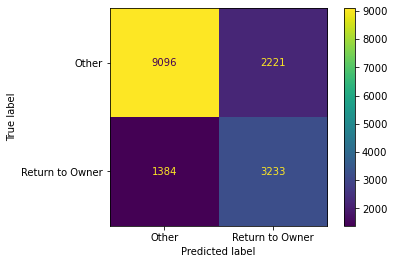

In [31]:
plot_confusion_matrix(clf, X_test, y_test);

In [37]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,intake_age_in_years,66.652232
1,intake_type,9.741070
2,breed,7.859004
3,intake_spay_neuter,5.071736
4,color,4.854067
5,found_city,3.594144
6,intake_sex,2.227747
7,intake_condition,0.000000


In [ ]:
use treeshap